In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cuda


In [2]:
# Paths
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")
TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

CONFIG = {
    'image_size': (128, 128),
    'latent_dim': 128,
    'batch_size': 64,
    'num_epochs': 25,
    'learning_rate': 2e-4,
    'patience': 5,
    'seeds': [42, 123, 456, 789, 1024],  # 5 seeds for ensemble
}

print(f"Will train {len(CONFIG['seeds'])} models")

Will train 5 models


In [3]:
def discover_frames(video_dir):
    frames = defaultdict(list)
    if not os.path.exists(video_dir):
        return frames
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        try:
            vid = int(os.path.basename(vf))
        except:
            continue
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except:
                continue
        frames[vid].sort(key=lambda x: x[0])
    return dict(frames)

train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)
print(f"Train: {sum(len(v) for v in train_frames.values())} frames")
print(f"Test: {sum(len(v) for v in test_frames.values())} frames")

Train: 9204 frames
Test: 11706 frames


In [4]:
test_frame_ids = []
test_frame_info = []
for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))
print(f"Test IDs: {len(test_frame_ids)}")

Test IDs: 11706


In [5]:
def load_to_gpu(frames_dict, image_size, device):
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    tensors = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    info = []
    idx = 0
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            img = Image.open(path).convert('RGB').resize((W, H), Image.BILINEAR)
            arr = np.array(img, dtype=np.float32) / 127.5 - 1.0
            tensors[idx] = torch.from_numpy(arr).permute(2, 0, 1)
            info.append((vid, fnum))
            idx += 1
    return tensors, info

print("Loading to GPU...")
train_tensors, train_info = load_to_gpu(train_frames, CONFIG['image_size'], DEVICE)
test_tensors, test_info = load_to_gpu(test_frames, CONFIG['image_size'], DEVICE)
print(f"GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading to GPU...
GPU: 4.11 GB


In [6]:
class SimpleAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
        )
        self.fc_enc = nn.Sequential(nn.Flatten(), nn.Linear(512*4*4, latent_dim))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 512*4*4), nn.LeakyReLU(0.2, True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh(),
        )
    
    def forward(self, x):
        z = self.fc_enc(self.encoder(x))
        return self.decoder(self.fc_dec(z).view(-1, 512, 4, 4))

In [7]:
def train_model(seed, train_tensors, config, device):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    model = SimpleAE(config['latent_dim']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    
    loader = DataLoader(TensorDataset(train_tensors), batch_size=config['batch_size'], shuffle=True)
    
    best_loss = float('inf')
    patience = 0
    best_state = None
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        for (batch,) in loader:
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(batch), batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
        
        if patience >= config['patience']:
            break
    
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_loss

In [8]:
print("=" * 60)
print("TRAINING ENSEMBLE")
print("=" * 60)

models = []
for i, seed in enumerate(CONFIG['seeds']):
    print(f"\nModel {i+1}/{len(CONFIG['seeds'])} (seed={seed})")
    model, loss = train_model(seed, train_tensors, CONFIG, DEVICE)
    models.append(model)
    print(f"  Best loss: {loss:.5f}")

print(f"\nTrained {len(models)} models")

TRAINING ENSEMBLE

Model 1/5 (seed=42)
  Best loss: 0.00218

Model 2/5 (seed=123)
  Best loss: 0.00213

Model 3/5 (seed=456)
  Best loss: 0.00232

Model 4/5 (seed=789)
  Best loss: 0.00226

Model 5/5 (seed=1024)
  Best loss: 0.00229

Trained 5 models


In [9]:
@torch.no_grad()
def get_max_scores(model, tensors, frame_info, batch_size=128):
    model.eval()
    scores = {}
    for start in range(0, len(tensors), batch_size):
        end = min(start + batch_size, len(tensors))
        batch = tensors[start:end]
        recon = model(batch)
        max_err = torch.amax((batch - recon) ** 2, dim=(1, 2, 3))
        for i, s in enumerate(max_err.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(s)
    return scores

print("Computing MAX scores from all models...")
all_max_scores = []
for i, model in enumerate(models):
    print(f"Model {i+1}...")
    scores = get_max_scores(model, test_tensors, test_info)
    all_max_scores.append(scores)
print("Done!")

Computing MAX scores from all models...
Model 1...
Model 2...
Model 3...
Model 4...
Model 5...
Done!


In [10]:
def normalize(scores, clip_pct=99):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    clip_val = np.percentile(vals, clip_pct)
    vals = np.clip(vals, 0, clip_val)
    v_min, v_max = vals.min(), vals.max()
    norm = (vals - v_min) / (v_max - v_min + 1e-8)
    return {k: float(norm[i]) for i, k in enumerate(keys)}

def ensemble_avg(score_list):
    keys = list(score_list[0].keys())
    return {k: np.mean([s[k] for s in score_list]) for k in keys}

def ensemble_median(score_list):
    keys = list(score_list[0].keys())
    return {k: np.median([s[k] for s in score_list]) for k in keys}

def ensemble_max(score_list):
    """Take max across models - if ANY model thinks it's anomaly, flag it."""
    keys = list(score_list[0].keys())
    return {k: np.max([s[k] for s in score_list]) for k in keys}

def ensemble_min(score_list):
    """Take min across models - conservative, only if ALL models agree."""
    keys = list(score_list[0].keys())
    return {k: np.min([s[k] for s in score_list]) for k in keys}

In [11]:
# Normalize individual model scores first
all_max_norm = [normalize(s) for s in all_max_scores]

# Create different ensembles
ensembles = {}

# Full ensemble (all 5 models)
ensembles['avg_all5'] = normalize(ensemble_avg(all_max_norm))
ensembles['median_all5'] = normalize(ensemble_median(all_max_norm))
ensembles['max_all5'] = normalize(ensemble_max(all_max_norm))

# 3-model ensembles (like our best 0.53)
ensembles['avg_3_v1'] = normalize(ensemble_avg(all_max_norm[:3]))  # seeds 42, 123, 456
ensembles['avg_3_v2'] = normalize(ensemble_avg(all_max_norm[1:4]))  # seeds 123, 456, 789
ensembles['avg_3_v3'] = normalize(ensemble_avg(all_max_norm[2:5]))  # seeds 456, 789, 1024

# Best single models
ensembles['single_seed42'] = all_max_norm[0]
ensembles['single_seed123'] = all_max_norm[1]
ensembles['single_seed456'] = all_max_norm[2]

# Weighted ensemble (more weight on certain models)
# We'll see which individual models do best and can adjust later

print(f"Created {len(ensembles)} ensemble strategies")

Created 9 ensemble strategies


In [12]:
def save_sub(scores, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in test_frame_ids])
    df.to_csv(os.path.join(OUTPUT_DIR, filename), index=False)
    print(f"Saved: {filename}")
    return df

for name, scores in ensembles.items():
    save_sub(scores, f'sub_{name}.csv')

print(f"\nGenerated {len(ensembles)} submissions")

Saved: sub_avg_all5.csv
Saved: sub_median_all5.csv
Saved: sub_max_all5.csv
Saved: sub_avg_3_v1.csv
Saved: sub_avg_3_v2.csv
Saved: sub_avg_3_v3.csv
Saved: sub_single_seed42.csv
Saved: sub_single_seed123.csv
Saved: sub_single_seed456.csv

Generated 9 submissions


In [13]:
import matplotlib.pyplot as plt

# Check correlation between models
print("Model correlations (higher = more similar):")
for i in range(len(all_max_norm)):
    for j in range(i+1, len(all_max_norm)):
        vals_i = np.array([all_max_norm[i][k] for k in test_frame_ids])
        vals_j = np.array([all_max_norm[j][k] for k in test_frame_ids])
        corr = np.corrcoef(vals_i, vals_j)[0, 1]
        print(f"  Model {i+1} vs Model {j+1}: {corr:.4f}")

Model correlations (higher = more similar):
  Model 1 vs Model 2: 0.9876
  Model 1 vs Model 3: 0.9871
  Model 1 vs Model 4: 0.9891
  Model 1 vs Model 5: 0.9888
  Model 2 vs Model 3: 0.9834
  Model 2 vs Model 4: 0.9819
  Model 2 vs Model 5: 0.9815
  Model 3 vs Model 4: 0.9889
  Model 3 vs Model 5: 0.9892
  Model 4 vs Model 5: 0.9914


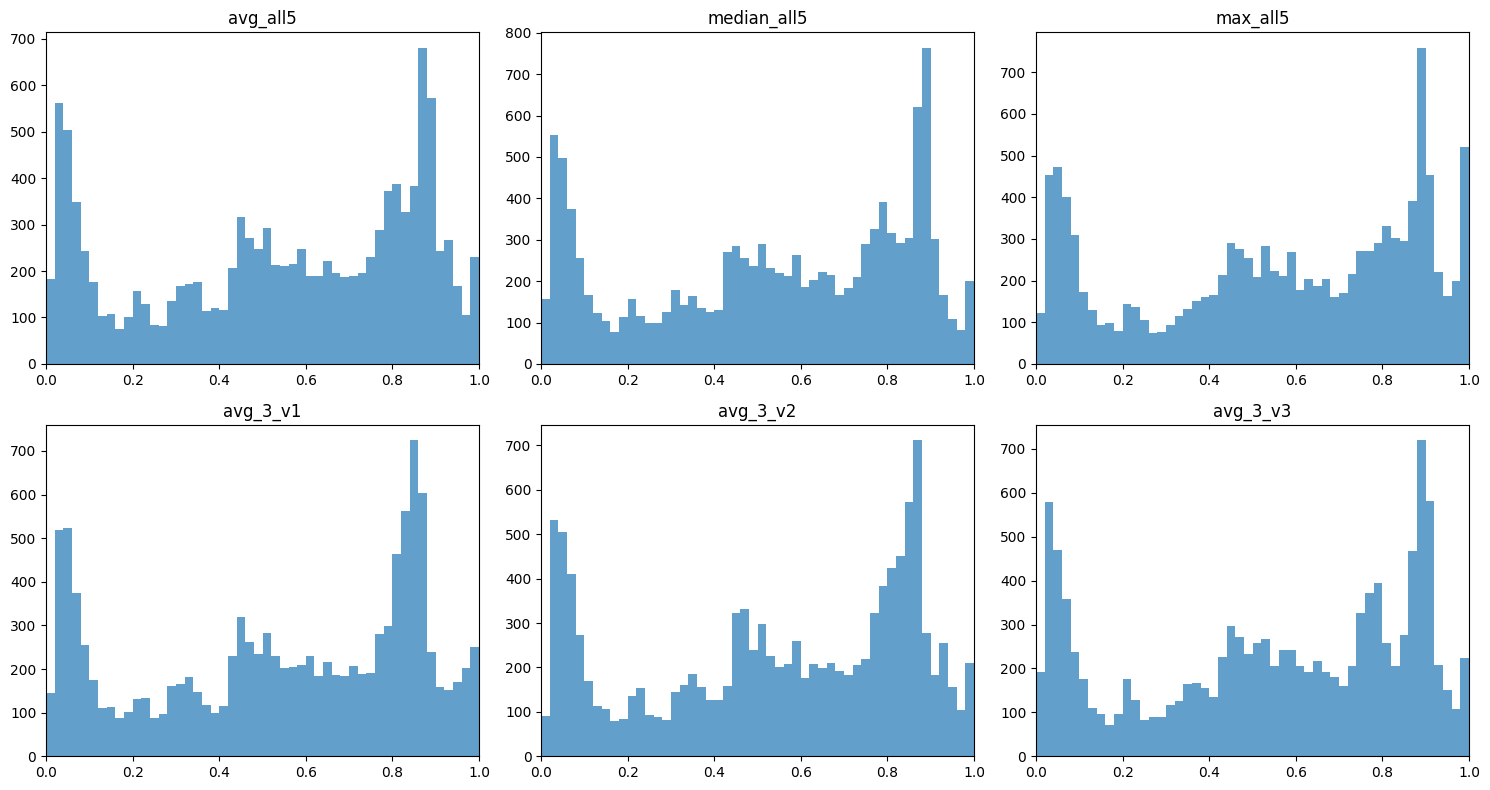

In [14]:
# Distribution comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, (name, scores) in enumerate(list(ensembles.items())[:6]):
    ax = axes[i // 3, i % 3]
    ax.hist(list(scores.values()), bins=50, alpha=0.7)
    ax.set_title(name)
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'ensemble_distributions.png'))
plt.show()